In [1]:
import numpy as np
import torch
import sys
sys.path.append('..')
import swag
import models

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
laplace_inclass = np.load('../swa_exps/unc_vgg_cifar10_0620/ent_laplace_0.npz')
laplace_outclass = np.load('../swa_exps/unc_vgg_cifar10_0620/ent_laplace_1.npz')

swa_inclass = np.load('../swa_exps/unc_vgg_cifar10_0620/ent_swa_0.npz')
swa_outclass = np.load('../swa_exps/unc_vgg_cifar10_0620/ent_swa_1.npz')

swag_cov_inclass = np.load('../swa_exps/unc_vgg_cifar10_0620/ent_swag_cov_0.npz')
swag_cov_outclass = np.load('../swa_exps/unc_vgg_cifar10_0620/ent_swag_cov_1.npz')

swag_nocov_inclass = np.load('../swa_exps/unc_vgg_cifar10_0620/ent_swag_nocov_0.npz')
swag_nocov_outclass = np.load('../swa_exps/unc_vgg_cifar10_0620/ent_swag_nocov_1.npz')

swag_laplace_inclass = np.load('../swa_exps/unc_vgg_cifar10_0620/ent_slaplace_0.npz')
swag_laplace_outclass = np.load('../swa_exps/unc_vgg_cifar10_0620/ent_slaplace_1.npz')

In [3]:
def plot_entropy(myax, inclass, outclass, label):
    #plt.figure(figsize=(12, 7))
    myax.set_title(str(label), fontsize=12)
    myax.set_xscale('log')
    bins = 10 ** np.linspace(-8, 0.5, 30)
    myax.hist(inclass, bins=bins, color='red')
    myax.hist(outclass, bins=bins, color='black', alpha=0.3)
    myax.set_ylim((0, 1000))
    #myax.show()

<Figure size 864x1152 with 0 Axes>

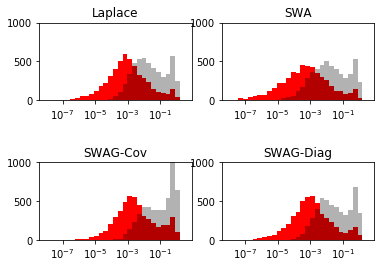

In [4]:
plt.close()
plt.figure(figsize=(12, 16))
f, axarr = plt.subplots(2, 2)
#f.xscale('log')
plt.title('Entropy Distributions')
plot_entropy(axarr[0,0], laplace_inclass['entropies'], laplace_outclass['entropies'], 'Laplace')
plot_entropy(axarr[0,1], swa_inclass['entropies'], swa_outclass['entropies'], 'SWA')
plot_entropy(axarr[1,0], swag_cov_inclass['entropies'], swag_cov_outclass['entropies'], 'SWAG-Cov')
plot_entropy(axarr[1,1], swag_nocov_inclass['entropies'], swag_nocov_outclass['entropies'], 'SWAG-Diag')
f.subplots_adjust(hspace=0.8)
#plt.show()
plt.savefig('../plots/cifar10_entropy_dists.eps')

Text(0,0.5,'SWAG-Laplace')

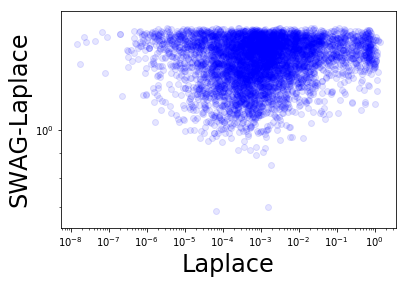

In [5]:
plt.xscale('log')
plt.yscale('log')
plt.scatter(laplace_inclass['entropies'], swag_laplace_inclass['entropies'], c='blue', alpha = 0.1)
#plt.plot(np.arange(1e-7,1.01,.01), np.arange(1e-7,1.01,.01), c='black')
plt.xlabel('Laplace', fontsize=24)
plt.ylabel('SWAG-Laplace', fontsize=24)


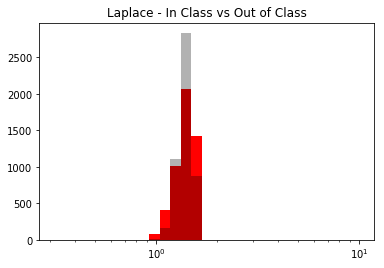

In [6]:
plt.title('Laplace - In Class vs Out of Class', fontsize=12)
plt.xscale('log')
bins = 10 ** np.linspace(-0.5, 1, 30)
plt.hist(swag_laplace_inclass['entropies'], bins=bins, color='red')
plt.hist(swag_laplace_outclass['entropies'], bins=bins, color='black', alpha=0.3)
plt.show()

In [7]:
print( (laplace_inclass['targets'] == swa_inclass['targets']).sum(),
        (swag_cov_inclass['targets'] == swa_inclass['targets']).sum(),
        (swag_nocov_inclass['targets'] == swa_inclass['targets']).sum() )
#labels = np.concatenate((swa_inclass['targets'], np.ones(5000) * -1))
in_out_labels = np.concatenate((np.zeros(5000), np.ones(5000)))

5000 5000 5000


In [8]:
from sklearn import metrics
from statsmodels.distributions.empirical_distribution import ECDF

def compute_auc_by_entropy_thresh(threshold, entropy, labels=in_out_labels):
    preds = entropy > threshold
    #entropy_quantiles = ECDF(entropy).y[1:]
    """print(len(entropy_quantiles), len(labels))
    fpr, tpr, thresholds = metrics.roc_curve(labels, entropy_quantiles, pos_label=2)
    print(thresholds)
    return metrics.auc(fpr, tpr)"""
    return metrics.roc_auc_score(y_true=labels, y_score=preds)

def compute_auc_by_entropy(entropy, labels=in_out_labels):
    #all_thresholds = np.unique(entropy)
    all_thresholds = np.percentile(entropy, np.arange(100))
    auc_scores = [compute_auc_by_entropy_thresh(t, entropy) for t in all_thresholds]
    return all_thresholds, auc_scores

In [9]:
laplace_entropy = np.concatenate((laplace_inclass['entropies'], laplace_outclass['entropies']))
slaplace_entropy = np.concatenate((swag_laplace_inclass['entropies'], swag_laplace_outclass['entropies']))
swa_entropy = np.concatenate((swa_inclass['entropies'], swa_outclass['entropies']))
swag_cov_entropy = np.concatenate((swag_cov_inclass['entropies'], swag_cov_outclass['entropies']))
swag_nocov_entropy = np.concatenate((swag_nocov_inclass['entropies'], swag_nocov_outclass['entropies']))

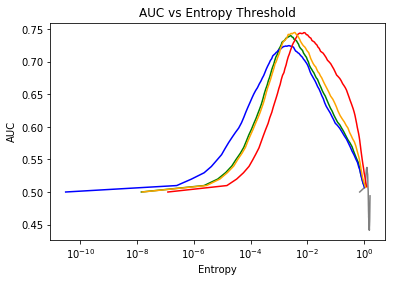

In [10]:
plt.xscale('log')

x, y = compute_auc_by_entropy(laplace_entropy)
plt.plot(x,y, c='green')
x, y = compute_auc_by_entropy(slaplace_entropy)
plt.plot(x,y, c='grey')
x, y = compute_auc_by_entropy(swa_entropy)
plt.plot(x,y, c='blue')
x, y = compute_auc_by_entropy(swag_cov_entropy)
plt.plot(x,y, c='red')
x, y = compute_auc_by_entropy(swag_nocov_entropy)
plt.plot(x,y, c='orange')
plt.ylabel('AUC')
plt.xlabel('Entropy')
plt.title('AUC vs Entropy Threshold')
#plt.show()
plt.savefig('../plots/cifar10_auc_entropy.eps')

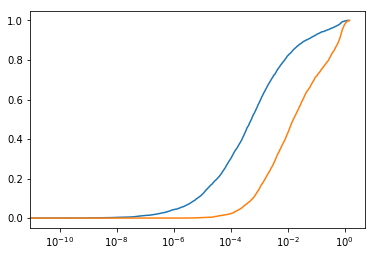

In [11]:
swa_entropy = np.concatenate((swa_inclass['entropies'], swa_outclass['entropies']))
colorvec = ['blue' if l==1 else 'green' for l in in_out_labels]
plt.xscale('log')
#plt.scatter(ECDF(swa_entropy).x, ECDF(swa_entropy).y, color=colorvec, alpha = 0.01)
#plt.xlim((1e-3, 1e-2))
in_ecdf = ECDF(swa_inclass['entropies'])
out_ecdf = ECDF(swa_outclass['entropies'])
plt.plot(in_ecdf.x, in_ecdf.y)
plt.plot(out_ecdf.x, out_ecdf.y)

<b>The plots below will be much more interesting on CIFAR 100 instead</b>

In [12]:
def compute_accuracy_by_entropy(entropy, preds, labels, bins=None):
    #def compute_acc_by_entropy_thresh(threshold, entropy, preds, labels):
    #    #
    #all_thresholds = np.unique(entropy)
    if bins is None:
        bins = np.percentile(entropy, np.arange(100))
    digitized = np.digitize(entropy, bins)
    accuracy = [np.sum(preds[digitized==i]==labels[digitized==i])/np.sum(digitized==i) for i in range(1, len(bins))]
    return accuracy, bins

In [13]:
laplace_inclass = np.load('../swa_exps/vgg16_cifar100_0620_1/ent_laplace.npz')

swa_inclass = np.load('../swa_exps/vgg16_cifar100_0620_1/ent_swa.pt.npz')

swag_cov_inclass = np.load('../swa_exps/vgg16_cifar100_0620_1/ent_swag_cov.pt.npz')

swag_nocov_inclass = np.load('../swa_exps/vgg16_cifar100_0620_1/ent_swag_nocov.pt.npz')

swag_laplace_inclass = np.load('../swa_exps/vgg16_cifar100_0620_1/ent_slaplace.npz')

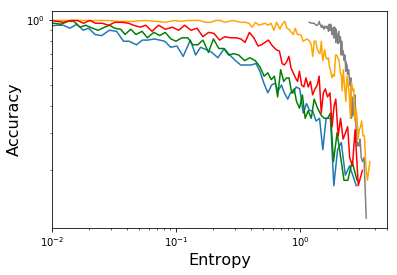

In [14]:
plt.xscale('log')
plt.yscale('log')
plt.xlim((0.01, 5))
acc, bins = compute_accuracy_by_entropy(swa_inclass['entropies'], np.argmax(swa_inclass['predictions'],1), swa_inclass['targets'])
plt.plot(bins[1:], acc)
acc, bins = compute_accuracy_by_entropy(laplace_inclass['entropies'], np.argmax(laplace_inclass['predictions'],1), swa_inclass['targets'])
plt.plot(bins[1:], acc, c='green')
acc, bins = compute_accuracy_by_entropy(swag_laplace_inclass['entropies'], np.argmax(swag_laplace_inclass['predictions'],1), swa_inclass['targets'])
plt.plot(bins[1:], acc, c='grey')
acc, bins = compute_accuracy_by_entropy(swag_cov_inclass['entropies'], np.argmax(swag_cov_inclass['predictions'],1), swa_inclass['targets'])
plt.plot(bins[1:], acc, c='orange')
acc, bins = compute_accuracy_by_entropy(swag_nocov_inclass['entropies'], np.argmax(swag_nocov_inclass['predictions'],1), swa_inclass['targets'])
plt.plot(bins[1:], acc, c='red')
plt.xlabel('Entropy', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
#plt.show()
plt.savefig('../plots/cifar100_entropy_accuracy.eps')

/Users/wesleymaddox/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  


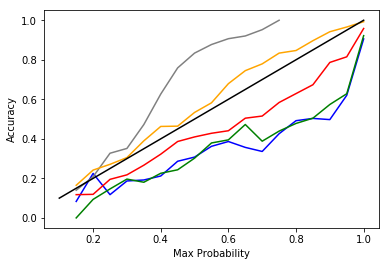

In [15]:
#plt.xscale('log')
acc, bins = compute_accuracy_by_entropy(np.max(swa_inclass['predictions'],1), 
                                        np.argmax(swa_inclass['predictions'],1), 
                                        swa_inclass['targets'], bins = np.arange(0.1, 1.05, 0.05))
plt.plot(bins[1:], acc, c='blue')
acc, bins = compute_accuracy_by_entropy(np.max(laplace_inclass['predictions'],1), 
                                        np.argmax(laplace_inclass['predictions'],1), 
                                        swa_inclass['targets'],
                                       bins = np.arange(0.1, 1.05, 0.05))
plt.plot(bins[1:], acc, c='green')
acc, bins = compute_accuracy_by_entropy(np.max(swag_laplace_inclass['predictions'],1), 
                                        np.argmax(swag_laplace_inclass['predictions'],1), 
                                        swag_laplace_inclass['targets'],
                                       bins = np.arange(0.1, 1.05, 0.05))
plt.plot(bins[1:], acc, c='grey')
acc, bins = compute_accuracy_by_entropy(np.max(swag_cov_inclass['predictions'],1), 
                                        np.argmax(swag_cov_inclass['predictions'],1), 
                                        swa_inclass['targets'], 
                                       bins = np.arange(0.1, 1.05, 0.05))
plt.plot(bins[1:], acc, c='orange')
acc, bins = compute_accuracy_by_entropy(np.max(swag_nocov_inclass['predictions'],1), 
                                        np.argmax(swag_nocov_inclass['predictions'],1), 
                                        swa_inclass['targets'],
                                       bins = np.arange(0.1, 1.05, 0.05))
plt.plot(bins[1:], acc, c='red')

plt.plot(np.arange(0.1,1.01,.01), np.arange(0.1,1.01,.01), c='black')

plt.xlabel('Max Probability')
plt.ylabel('Accuracy')
#plt.show()
plt.savefig('../plots/cifar100_calibration_v1.eps')

Text(0,0.5,'Count')

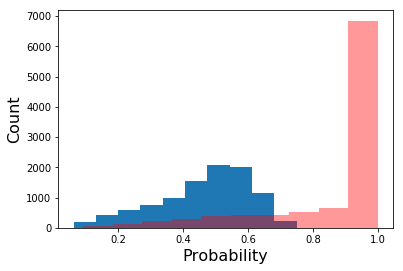

In [16]:
plt.hist(np.max(swag_laplace_inclass['predictions'],1))
plt.hist(np.max(laplace_inclass['predictions'],1),color='red',alpha=0.4)
plt.xlabel('Probability', fontsize=16)
plt.ylabel('Count', fontsize=16)